In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `C:\Users\asus`


In [2]:
Pkg.add(["LinearAlgebra", "FFTW", "Plots", "Optimisers","MAT","Statistics","Convex","SCS"])

   Resolving package versions...
  No Changes to `C:\Users\asus\Project.toml`
  No Changes to `C:\Users\asus\Manifest.toml`


In [3]:
using LinearAlgebra, FFTW, Plots, Optimisers, MAT, Statistics, Convex, SCS

In [52]:
# loading .mat measurement files
file_path = "E:/Education/Stony Brook University - PhD/Fall 2024/BME 574/project/data.mat"
data = matread(file_path)
data = collect(values(data))
data = data[1]

5534×3 Matrix{Float64}:
  9.52  -0.0           0.0
  9.53  -4.28159e-6    7.55534e-7
  9.54  -1.52843e-5    2.21696e-7
  9.55  -3.26319e-5   -5.78036e-6
  9.56  -5.94786e-5   -2.09472e-5
  9.57  -9.25125e-5   -4.47882e-5
  9.58  -0.000110072  -6.86395e-5
  9.59  -0.000149741  -0.000101563
  9.6   -0.000199798  -0.000134853
  9.61  -0.000236367  -0.000155293
  9.62  -0.000267301  -0.000160508
  9.63  -0.000358297  -0.000168775
  9.64  -0.00038923   -0.000138887
  ⋮                   
 64.74  -0.0           0.0
 64.75  -0.0           0.0
 64.76  -0.0           0.0
 64.77  -0.0           0.0
 64.78  -0.0           0.0
 64.79  -0.0           0.0
 64.8   -0.0          -0.0
 64.81  -0.0          -0.0
 64.82  -0.0          -0.0
 64.83  -0.0          -0.0
 64.84  -0.0          -0.0
 64.85  -0.0           0.0

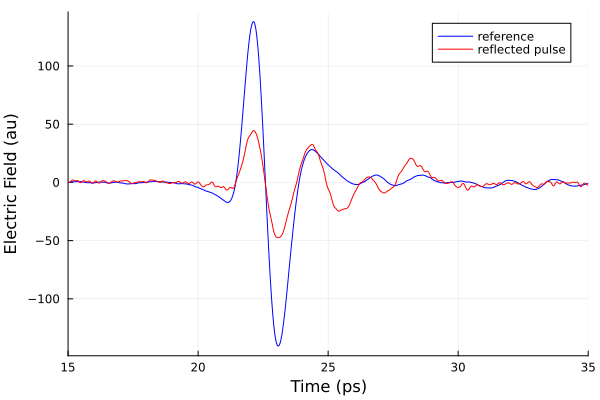

In [53]:
# electric field vectors and time axis
er = data[:,3] # reflected electric field time domain
ei = data[:,2] # reference (incident beam) electric field time domain
t = data[:,1] # time axis (unit: ps)
Ts = mean(t[2] - t[1]) # sampling time (unit: ps)
Fs = 1/Ts # sampling rate (unit: THz)
N = length(t) # signal length
f = 0:Fs/(N-1):Fs
Plots.plot(t, ei, xlabel="Time (ps)", ylabel="Electric Field (au)",label="reference",lwidth=2, color="blue")
Plots.plot!(t, er,label="reflected pulse",lwidth=2, color="red", xlims=(15, 35))

In [54]:
# normal frequency domain deconvolution
Er = fft(er) # frequency domain of reflected pulse
Ei = fft(ei) # frequency domain of incident pulse
H1 = Er ./ Ei; # transfer function
idx = Int(round(N/2))
H1[idx+1:end] .= reverse(conj.(H1[1:idx])) # performing Hermitian symmetric
h1 = ifft(H1) # impulse response

t2 = t .- t[idx]
h1 = real.(circshift(h1, idx))

5534-element Vector{Float64}:
  0.0
  4.9100122477275054e-5
  0.00011048037326453069
  0.00017869290686806905
  0.0002470028985267598
  0.0003082987530401671
  0.0003550473657275307
  0.00038039442129409454
  0.0003789412465472654
  0.0003464640025185718
  0.0002810851044969244
  0.00018357581073961336
  5.726396689304654e-5
  ⋮
  0.00044509827160786684
  0.0003824802546378664
  0.00031762701831636114
  0.0002513150955886613
  0.0001853830750241774
  0.00012198452631685904
  6.397656307999455e-5
  1.4681058127632216e-5
 -2.227181180606142e-5
 -4.38050540817161e-5
 -4.765983326213028e-5
 -3.291730077652469e-5

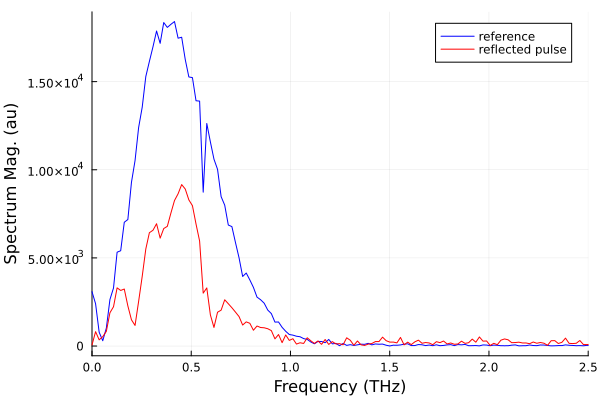

In [55]:
Plots.plot(f, abs.(Ei), xlabel="Frequency (THz)", ylabel="Spectrum Mag. (au)",label="reference",lwidth=2, color="blue")
Plots.plot!(f, abs.(Er),label="reflected pulse",lwidth=2, color="red", xlims=(0, 2.5))

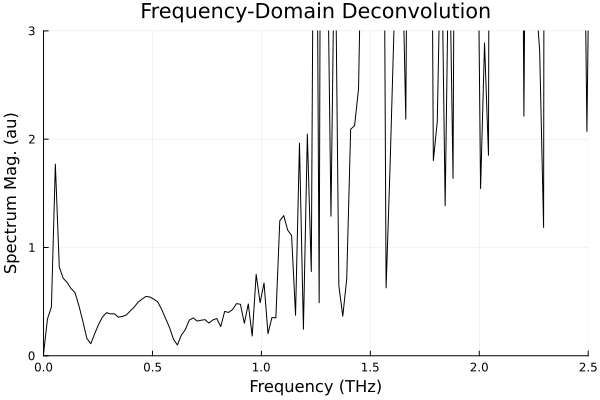

In [56]:
p1 = Plots.plot(f, abs.(H1), 
    title="Frequency-Domain Deconvolution", 
    xlabel="Frequency (THz)", 
    ylabel="Spectrum Mag. (au)", 
    xlims=(0,2.5),
    ylim=(0,3), 
    legend=false, 
    color="black",
    lwidth=2)

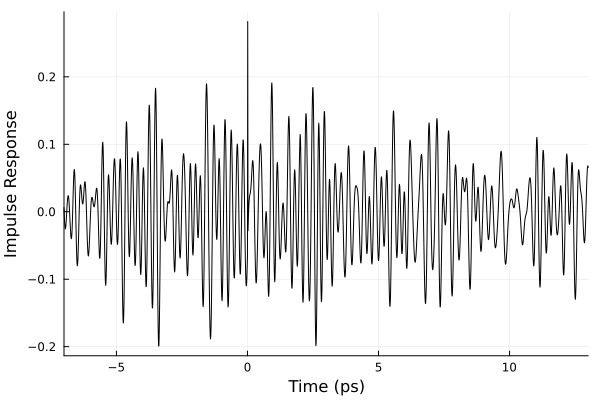

In [57]:
p2 = Plots.plot(t2, h1, 
    xlabel="Time (ps)", 
    ylabel="Impulse Response", 
    xlims=(-7, 13), 
    legend=false,
    color="black",
    lwidth=2)

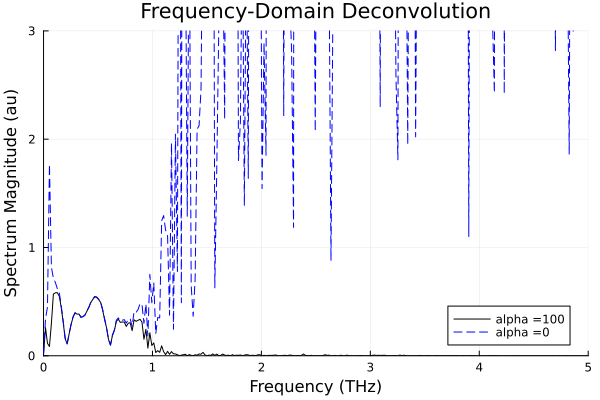

In [69]:
# wiener deconvolution
df = f[2] - f[1] # frequency resolution
alpha = 100 # regularization term
s = sum(abs.(Ei)) * df # expected value of spectrum
H2 = (Er .* conj.(Ei)) ./ (abs.(Ei).^2 .+ alpha * s)
H2[idx+1:end] .= reverse(conj.(H2[1:idx]))
h2 = ifft(H2)
h2 = circshift(h2, idx)
h2 = real.(h2)
p1 = Plots.plot(f, abs.(H2), 
    title="Wiener Deconvolution", 
    xlabel="Frequency (THz)", 
    ylabel="Spectrum Magnitude (au)", 
    xlims=(0,5),
    ylim=(0,3), 
    label="alpha =100",
    color="black",
    lwidth=2,)
p1 = Plots.plot!(f, abs.(H1), 
    title="Frequency-Domain Deconvolution", 
    xlabel="Frequency (THz)", 
    ylabel="Spectrum Magnitude (au)", 
    xlims=(0,5),
    ylim=(0,3), 
    color="blue",
    label="alpha =0",
    legend=:bottomright,
    lwidth=2,
    linestyle=:dash)

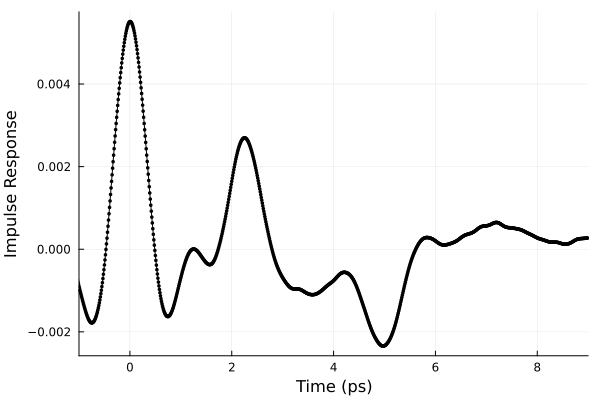

In [70]:
p2 = Plots.plot(t2, h2, 
    xlabel="Time (ps)", 
    ylabel="Impulse Response", 
    xlims=(-1, 9), 
    legend=false,
    color="black",
    lwidth=2,
    marker=:circle,
    markersize=2)
p2

In [18]:
# sparse deconvolution function - iterative shrinkage algorithm
function sparsedeconv(x, y, τ, λ, max_iter, max_err)
    N = length(x)
    X = zeros(N,N)
    for i in 1:N
        X[i,:] = circshift(reverse(x), i) # deconvolution matrix
    end
    τ = 2 * τ / norm(X * transpose(X))
    h = zeros(N,1) # initial value
    dh = 2 * max_err
    i = 0
    while (i <= max_iter && dh > max_err)
        h_new = h - τ .* transpose(X) * (X * h - y)
        dh = maximum(abs.(h_new - h))
        # soft thresholding
        h = zeros(N,1)
        h[h_new .<= -λ * τ] = h_new[h_new .<= -λ * τ] .+ λ * τ
        h[h_new .>= λ * τ] = h_new[h_new .>= λ * τ] .- λ * τ
        i = i + 1
    end
    return h
end

sparsedeconv (generic function with 1 method)

In [62]:
h3 = sparsedeconv(ei, er, 1, 8000, 1000, 1e-7)
h3 = circshift(h3, idx)


5534×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

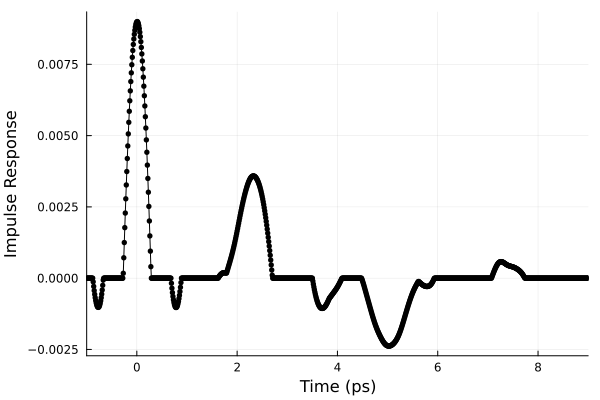

In [63]:
Plots.plot(t2, h3, 
    xlabel="Time (ps)", 
    ylabel="Impulse Response", 
    xlims=(-1, 9), 
    legend=false,
    color="black",
    lwidth=2,
    marker=:circle,
    markersize=3)